# 10FreqClasses

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=240
img_width=240
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1279 files belonging to 10 classes.
Using 1024 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['2WayFoleyCatheter', 'CottonBall', 'ExtensionTube', 'Glove', 'Mask', 'NGTube', 'Needle', 'OxygenMask', 'Syringe', 'UrineBag']
number of class = 10


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1279 files belonging to 10 classes.
Using 255 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 507 files belonging to 10 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1020 files belonging to 10 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 569 files belonging to 10 classes.


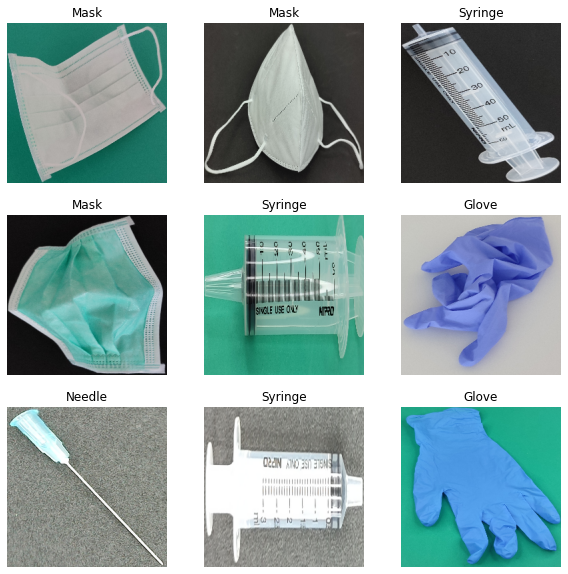

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 240, 240, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB1

efficientnetB0_model = keras.applications.EfficientNetB1(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB0_model_nooutput = efficientnetB0_model.layers[-3].output
custom_efficientnetB0_model = Model(inputs = efficientnetB0_model.input, outputs = efficientnetB0_model_nooutput)


## Freez Extractor+

In [18]:
custom_efficientnetB0_model.trainable = False
for layer in custom_efficientnetB0_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB0_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 240, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 241, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_efficientnetB0_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB0_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              6575239   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 7,897,233
Trainable params: 1,321,994
Non-trainable params: 6,575,239
_________________________________________________________________


In [22]:
#class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
16/16 [==============================] - 24s 467ms/step - loss: 0.4973 - accuracy: 0.8477 - val_loss: 0.0560 - val_accuracy: 0.9843
Epoch 2/2000
16/16 [==============================] - 3s 182ms/step - loss: 0.0381 - accuracy: 0.9883 - val_loss: 0.0256 - val_accuracy: 0.9922
Epoch 3/2000
16/16 [==============================] - 3s 181ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 4/2000
16/16 [==============================] - 3s 182ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 5/2000
16/16 [==============================] - 3s 181ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 6/2000
16/16 [==============================] - 3s 180ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 7/2000
16/16 [==============================] - 3s 181ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
16/16 [==============================] - 3s 177ms/step - loss: 7.6027e-04 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 202/2000
16/16 [==============================] - 3s 176ms/step - loss: 5.6973e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 203/2000
16/16 [==============================] - 3s 176ms/step - loss: 3.9339e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 204/2000
16/16 [==============================] - 3s 175ms/step - loss: 6.1081e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 205/2000
16/16 [==============================] - 3s 175ms/step - loss: 6.5795e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 206/2000
16/16 [==============================] - 3s 177ms/step - loss: 5.5057e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 207/2000
16/16 [==============================] - 3s 176ms/step - loss: 6.3034e-04 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
16/16 [==============================] - 3s 177ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 402/2000
16/16 [==============================] - 3s 176ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 403/2000
16/16 [==============================] - 3s 176ms/step - loss: 2.9499e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 404/2000
16/16 [==============================] - 3s 176ms/step - loss: 6.0452e-04 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 405/2000
16/16 [==============================] - 3s 175ms/step - loss: 3.1282e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 406/2000
16/16 [==============================] - 3s 175ms/step - loss: 2.3768e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 407/2000
16/16 [==============================] - 3s 175ms/step - loss: 2.9559e-04 - accuracy: 1.0000 

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
16/16 [==============================] - 3s 178ms/step - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 602/2000
16/16 [==============================] - 3s 178ms/step - loss: 1.3639e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 603/2000
16/16 [==============================] - 3s 178ms/step - loss: 2.3120e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 604/2000
16/16 [==============================] - 3s 179ms/step - loss: 1.5682e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 605/2000
16/16 [==============================] - 3s 178ms/step - loss: 2.2924e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 606/2000
16/16 [==============================] - 3s 178ms/step - loss: 1.8725e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 607/2000
16/16 [==============================] - 3s 178ms/step - loss: 1.7062e-04 - accuracy: 1.0

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
16/16 [==============================] - 3s 177ms/step - loss: 1.4758e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 802/2000
16/16 [==============================] - 3s 176ms/step - loss: 1.2818e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 803/2000
16/16 [==============================] - 3s 176ms/step - loss: 8.3729e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 804/2000
16/16 [==============================] - 3s 176ms/step - loss: 9.8939e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 805/2000
16/16 [==============================] - 3s 176ms/step - loss: 9.1037e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 806/2000
16/16 [==============================] - 3s 176ms/step - loss: 1.1619e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 807/2000
16/16 [==============================] - 3s 176ms/step - loss: 1.6970e-04 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
16/16 [==============================] - 3s 180ms/step - loss: 5.1110e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1002/2000
16/16 [==============================] - 3s 179ms/step - loss: 5.8300e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 1003/2000
16/16 [==============================] - 3s 179ms/step - loss: 0.0014 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1004/2000
16/16 [==============================] - 3s 178ms/step - loss: 3.9701e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1005/2000
16/16 [==============================] - 3s 178ms/step - loss: 3.6516e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 1006/2000
16/16 [==============================] - 3s 178ms/step - loss: 7.3400e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1007/2000
16/16 [==============================] - 3s 177ms/step - loss: 3.9303e-05 - accura

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
16/16 [==============================] - 3s 177ms/step - loss: 5.6421e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1202/2000
16/16 [==============================] - 3s 177ms/step - loss: 3.9602e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1203/2000
16/16 [==============================] - 3s 176ms/step - loss: 2.0874e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1204/2000
16/16 [==============================] - 3s 176ms/step - loss: 4.4103e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1205/2000
16/16 [==============================] - 3s 175ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1206/2000
16/16 [==============================] - 3s 176ms/step - loss: 6.2053e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1207/2000
16/16 [==============================] - 3s 176ms/step - loss: 0.0050 - accuracy: 

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
16/16 [==============================] - 3s 178ms/step - loss: 5.3834e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1402/2000
16/16 [==============================] - 3s 177ms/step - loss: 3.4480e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1403/2000
16/16 [==============================] - 3s 178ms/step - loss: 5.5251e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1404/2000
16/16 [==============================] - 3s 178ms/step - loss: 4.0636e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1405/2000
16/16 [==============================] - 3s 177ms/step - loss: 2.9836e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1406/2000
16/16 [==============================] - 3s 177ms/step - loss: 1.2250e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1407/2000
16/16 [==============================] - 3s 178ms/step - loss: 8.2939e-05 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
16/16 [==============================] - 3s 175ms/step - loss: 1.9669e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1602/2000
16/16 [==============================] - 3s 176ms/step - loss: 2.9025e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1603/2000
16/16 [==============================] - 3s 175ms/step - loss: 1.9439e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1604/2000
16/16 [==============================] - 3s 175ms/step - loss: 2.5271e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1605/2000
16/16 [==============================] - 3s 175ms/step - loss: 2.2968e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1606/2000
16/16 [==============================] - 3s 175ms/step - loss: 3.0161e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 1607/2000
16/16 [==============================] - 3s 175ms/step - loss: 2.6206e-05 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
16/16 [==============================] - 3s 179ms/step - loss: 2.4158e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1802/2000
16/16 [==============================] - 3s 178ms/step - loss: 1.6241e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1803/2000
16/16 [==============================] - 3s 178ms/step - loss: 3.2503e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1804/2000
16/16 [==============================] - 3s 177ms/step - loss: 4.4380e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1805/2000
16/16 [==============================] - 3s 178ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1806/2000
16/16 [==============================] - 3s 178ms/step - loss: 1.0197e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 1807/2000
16/16 [==============================] - 3s 178ms/step - loss: 1.9736e-05 - accura

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

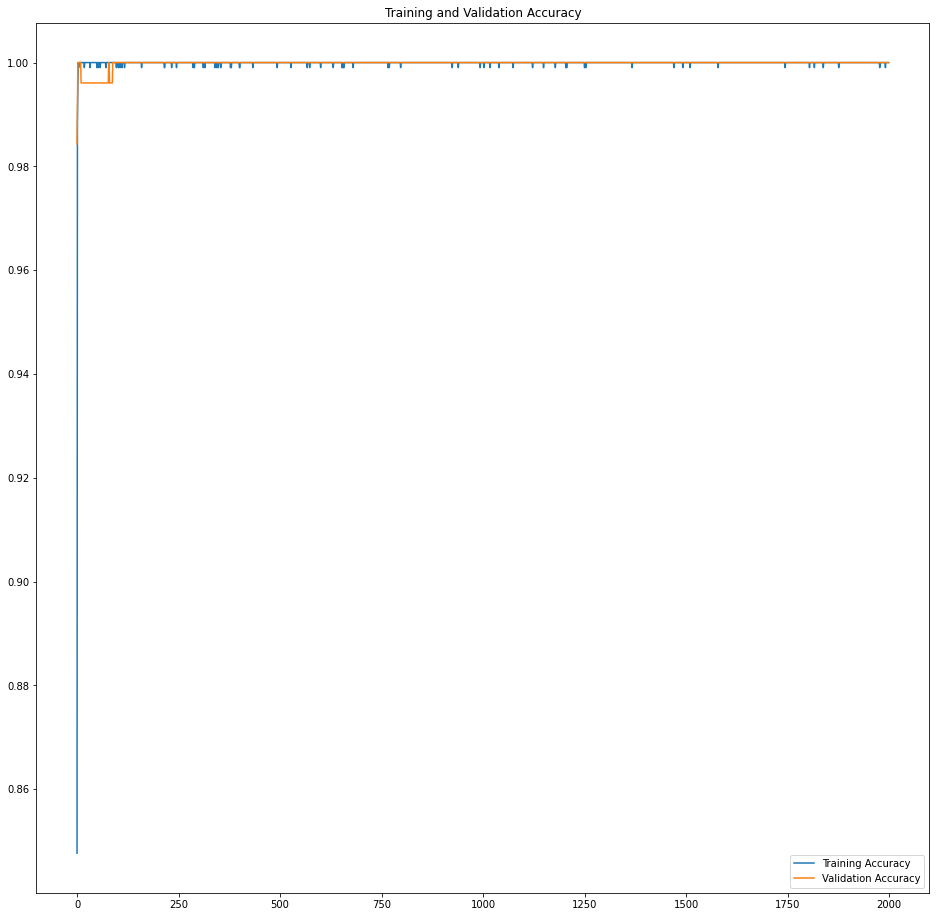

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


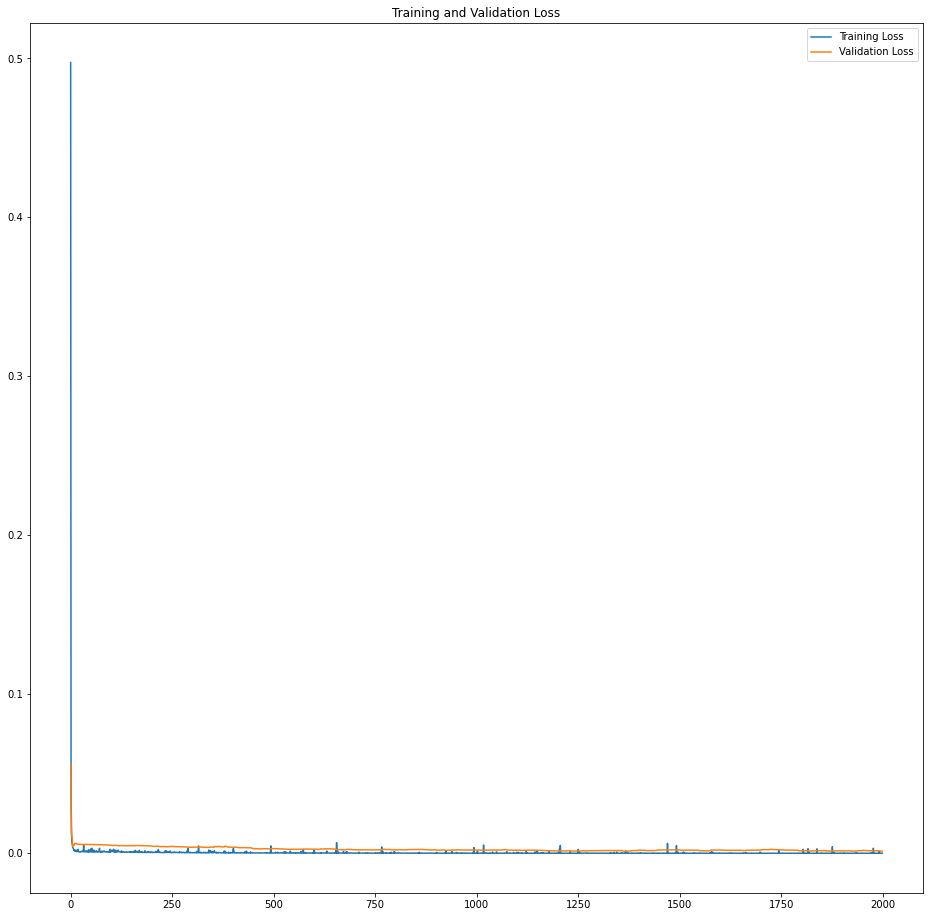

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

8/8 [==============================] - 5s 247ms/step - loss: 0.0379 - accuracy: 0.9822
test_indoor_ds_results:test loss, test acc: [0.037948038429021835, 0.9822485446929932]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

16/16 [==============================] - 9s 336ms/step - loss: 0.4565 - accuracy: 0.8961
test_outdoor_ds_results:test loss, test acc: [0.456500381231308, 0.8960784077644348]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

9/9 [==============================] - 3s 234ms/step - loss: 0.7224 - accuracy: 0.8436
test_belt_ds_results:test loss, test acc: [0.7224257588386536, 0.8435852527618408]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1000.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1200.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1400.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_EfficientNetB1/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_Efficien

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

9/9 [==============================] - 1s 137ms/step - loss: 0.5748 - accuracy: 0.8348
Epoch200 
 test_indoor_acc=0.9802761077880859 
 test_outdoor_acc=0.908823549747467 
 test_belt_acc=0.8347979187965393


9/9 [==============================] - 1s 137ms/step - loss: 0.6144 - accuracy: 0.8383
Epoch400 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.908823549747467 
 test_belt_acc=0.8383128046989441


9/9 [==============================] - 1s 136ms/step - loss: 0.6499 - accuracy: 0.8418
Epoch600 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.906862735748291 
 test_belt_acc=0.8418277502059937


9/9 [==============================] - 1s 136ms/step - loss: 0.6529 - accuracy: 0.8524
Epoch800 
 test_indoor_acc=0.9842209219932556 
 test_outdoor_acc=0.9107843041419983 
 test_belt_acc=0.8523725867271423


9/9 [==============================] - 1s 137ms/step - loss: 0.6713 - accuracy: 0.8471
Epoch1000 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.9107843041419983 
 test_belt_acc=0.8471001982688904


9/9 [==============================] - 1s 136ms/step - loss: 0.7039 - accuracy: 0.8471
Epoch1200 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.9098039269447327 
 test_belt_acc=0.8471001982688904


9/9 [==============================] - 1s 137ms/step - loss: 0.7119 - accuracy: 0.8348
Epoch1400 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.9078431129455566 
 test_belt_acc=0.8347979187965393


9/9 [==============================] - 1s 137ms/step - loss: 0.7215 - accuracy: 0.8471
Epoch1600 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.9039215445518494 
 test_belt_acc=0.8471001982688904


9/9 [==============================] - 1s 137ms/step - loss: 0.7082 - accuracy: 0.8489
Epoch1800 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.9078431129455566 
 test_belt_acc=0.8488576412200928


9/9 [==============================] - 1s 137ms/step - loss: 0.7224 - accuracy: 0.8436
Epoch2000 
 test_indoor_acc=0.9822485446929932 
 test_outdoor_acc=0.8960784077644348 
 test_belt_acc=0.8435852527618408


In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

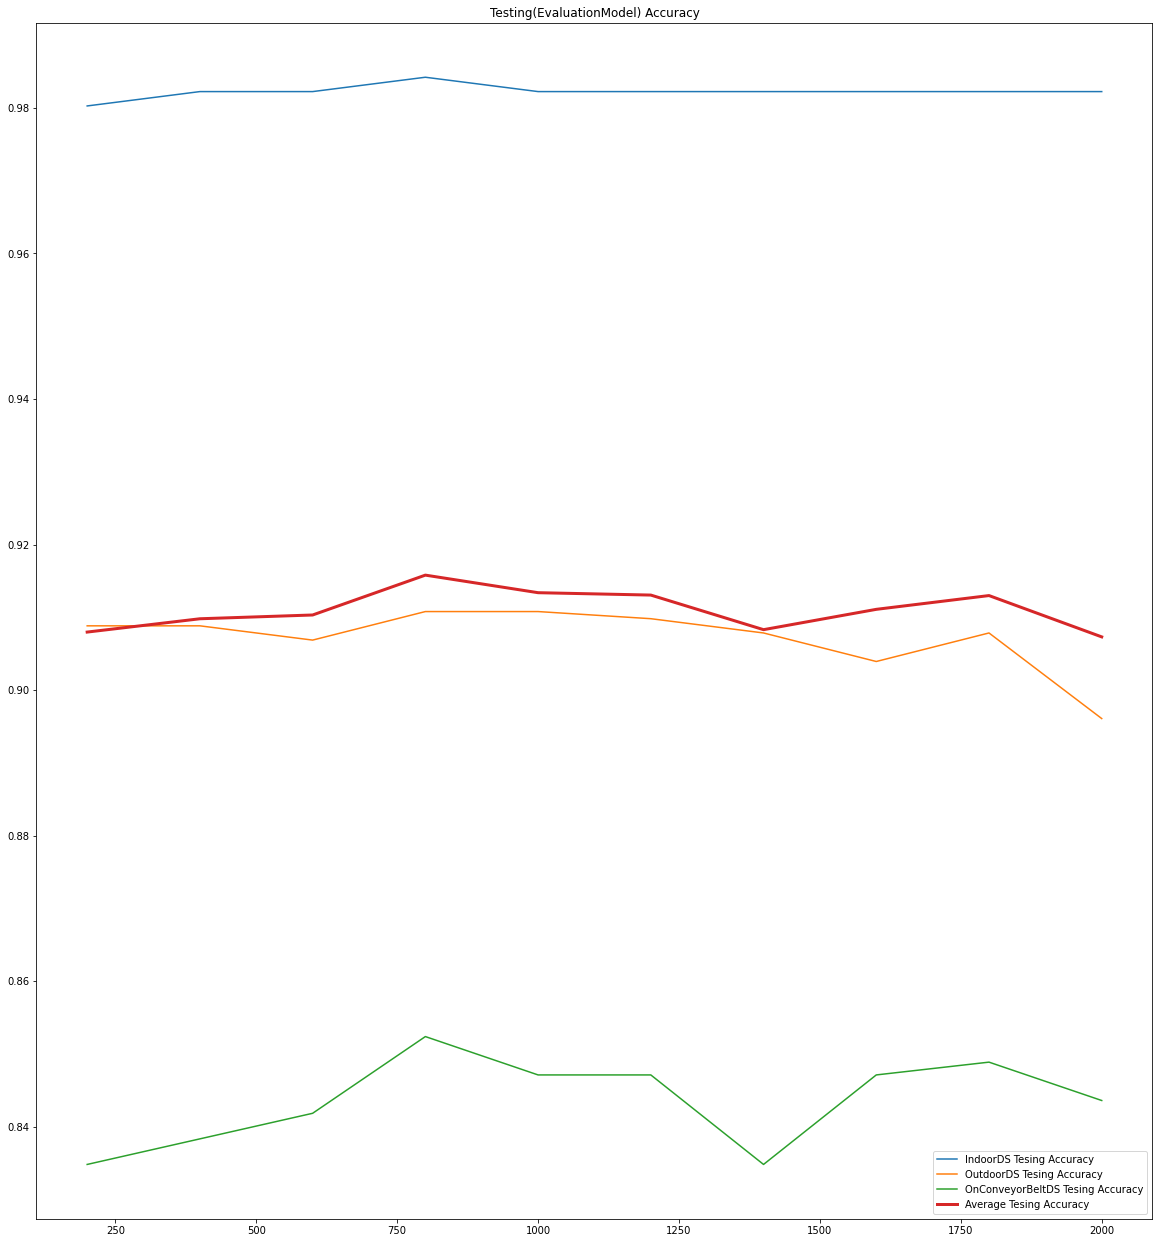

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.9157926042874655
max index -> 3
The [Epoch] of max acc -> 800


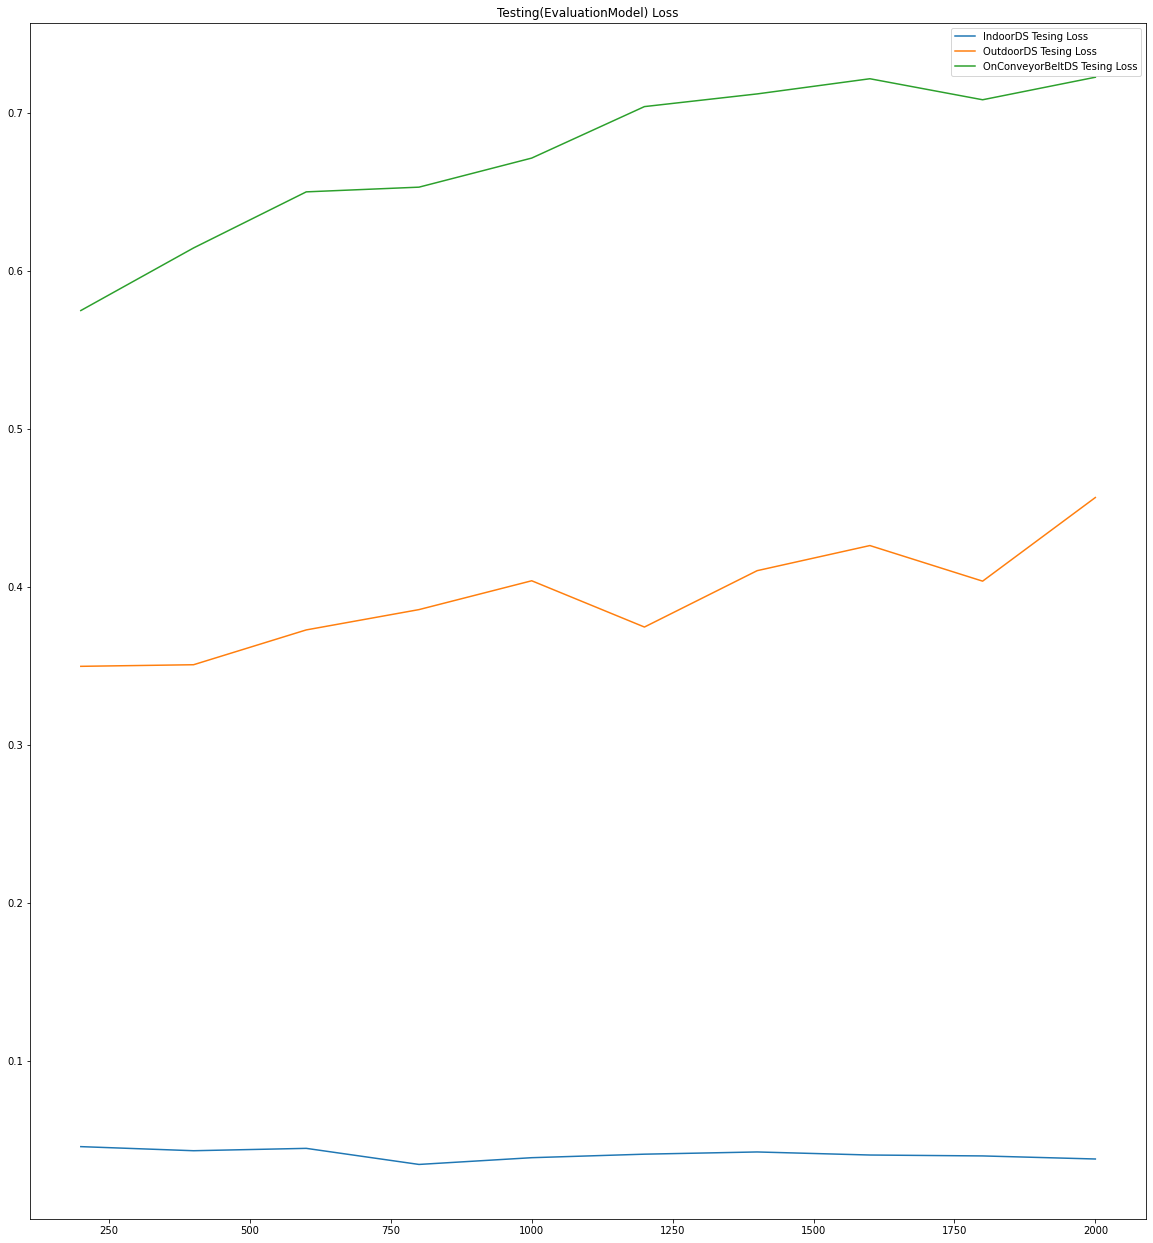

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.9802761077880859,
 0.9822485446929932,
 0.9822485446929932,
 0.9842209219932556,
 0.9822485446929932,
 0.9822485446929932,
 0.9822485446929932,
 0.9822485446929932,
 0.9822485446929932,
 0.9822485446929932]

In [38]:
test_outdoor_acc

[0.908823549747467,
 0.908823549747467,
 0.906862735748291,
 0.9107843041419983,
 0.9107843041419983,
 0.9098039269447327,
 0.9078431129455566,
 0.9039215445518494,
 0.9078431129455566,
 0.8960784077644348]

In [39]:
test_belt_acc

[0.8347979187965393,
 0.8383128046989441,
 0.8418277502059937,
 0.8523725867271423,
 0.8471001982688904,
 0.8471001982688904,
 0.8347979187965393,
 0.8471001982688904,
 0.8488576412200928,
 0.8435852527618408]

In [40]:
test_indoor_loss

[0.045774441212415695,
 0.04318369925022125,
 0.044682200998067856,
 0.03450630605220795,
 0.038773756474256516,
 0.041001953184604645,
 0.042402233928442,
 0.04046733304858208,
 0.03989198058843613,
 0.037948038429021835]

In [41]:
test_outdoor_loss

[0.34968292713165283,
 0.3506909906864166,
 0.37272346019744873,
 0.3855772912502289,
 0.40382033586502075,
 0.3745444416999817,
 0.4102141857147217,
 0.4261019229888916,
 0.4035787582397461,
 0.456500381231308]

In [42]:
test_belt_loss

[0.5748016834259033,
 0.614398717880249,
 0.6498997807502747,
 0.6528763175010681,
 0.6712778806686401,
 0.7038509845733643,
 0.7118777632713318,
 0.7214745879173279,
 0.7081745862960815,
 0.7224257588386536]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.efficientnet import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb')

test_indoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=240
img_width=240
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  #ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['2WayFoleyCatheter', 'CottonBall', 'ExtensionTube', 'Glove', 'Mask', 'NGTube', 'Needle', 'OxygenMask', 'Syringe', 'UrineBag']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)
del x_test_indoor,x_test_outdoor,x_test_belt
del x_all

Found 507 files belonging to 10 classes.
Found 1020 files belonging to 10 classes.
Found 569 files belonging to 10 classes.
train_indoor num x,y : 507,507
train_outdoor num x,y : 1020,1020
train_belt num x,y : 569,569
all num x,y :2096,2096


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=2096
TP=1913
FP=183
acc=0.9126908396946565
all check = 2096


### acc

In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


2WayFoleyCatheter acc = 79.1044776119403%
CottonBall acc = 98.20359281437125%
ExtensionTube acc = 72.35772357723577%
Glove acc = 96.13095238095238%
Mask acc = 99.48051948051948%
NGTube acc = 57.41935483870968%
Needle acc = 93.21428571428572%
OxygenMask acc = 94.73684210526315%
Syringe acc = 99.23954372623575%
UrineBag acc = 92.5%



all_avg_eachclass = 88.23872922495134%


In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[106,   0,   2,   9,   0,   4,   8,   0,   1,   4],
       [  0, 164,   0,   0,   2,   0,   0,   0,   0,   1],
       [  1,   0,  89,   0,  15,  15,   0,   0,   2,   1],
       [  8,   0,   0, 323,   4,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0, 383,   0,   0,   1,   1,   0],
       [  0,   0,  10,   0,  41,  89,   2,   5,   7,   1],
       [  0,   0,   0,   0,   2,   5, 261,   1,   9,   2],
       [  0,   0,   1,   0,   0,   0,   1, 126,   0,   5],
       [  0,   0,   0,   0,   1,   0,   1,   0, 261,   0],
       [  0,   0,   0,   0,   4,   0,   0,   5,   0, 111]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[79.10447761,  0.        ,  1.49253731,  6.71641791,  0.        ,
         2.98507463,  5.97014925,  0.        ,  0.74626866,  2.98507463],
       [ 0.        , 98.20359281,  0.        ,  0.        ,  1.19760479,
         0.        ,  0.        ,  0.        ,  0.        ,  0.5988024 ],
       [ 0.81300813,  0.        , 72.35772358,  0.        , 12.19512195,
        12.19512195,  0.        ,  0.        ,  1.62601626,  0.81300813],
       [ 2.38095238,  0.        ,  0.        , 96.13095238,  1.19047619,
         0.        ,  0.        ,  0.        ,  0.        ,  0.29761905],
       [ 0.        ,  0.        ,  0.        ,  0.        , 99.48051948,
         0.        ,  0.        ,  0.25974026,  0.25974026,  0.        ],
       [ 0.        ,  0.        ,  6.4516129 ,  0.        , 26.4516129 ,
        57.41935484,  1.29032258,  3.22580645,  4.51612903,  0.64516129],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.71428571,
         1.78571429, 93.21428571,  0.35714286

<AxesSubplot:>

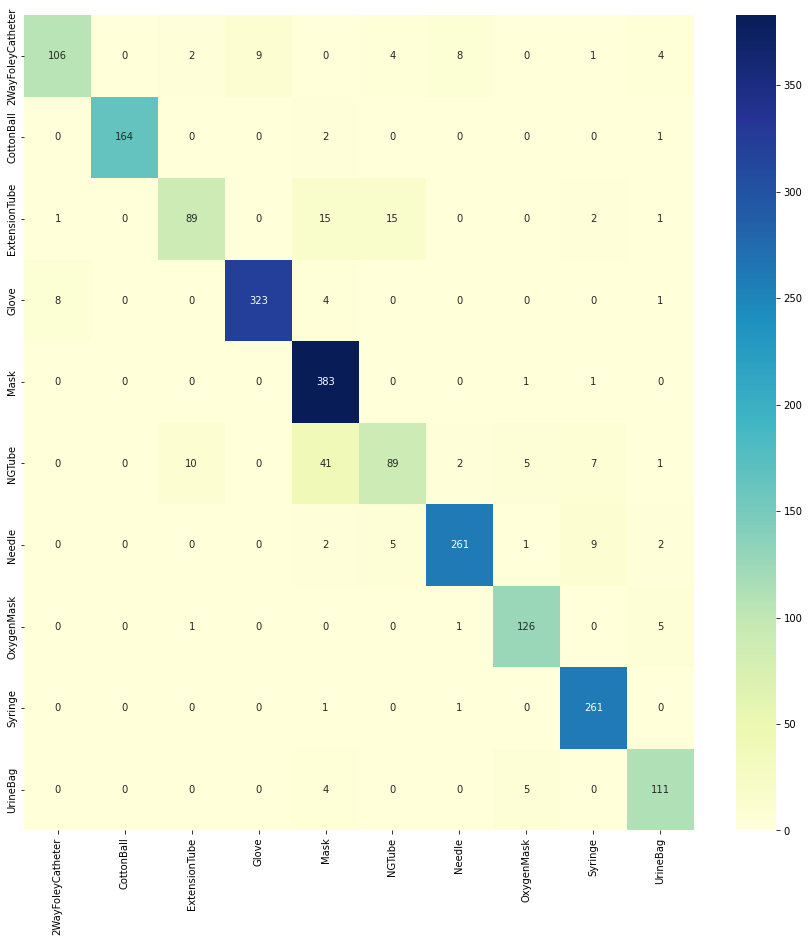

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

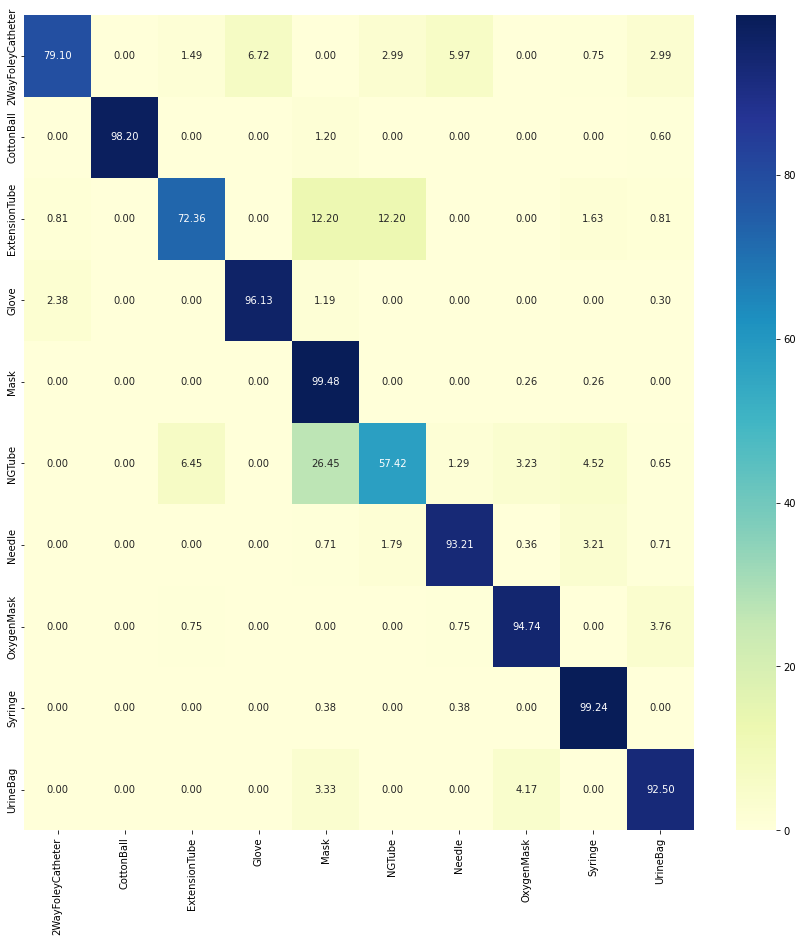

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")